Neste algoritmo, os algoritmos KNN e Random Forest serão aplicados para prever as classificações de aplicativos na Google Play Store.

In [387]:
import re
import sys

import time
import datetime
import statistics
import missingno as msno
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn import metrics
from scipy.stats import wilcoxon
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

# Loading the data
df = pd.read_csv('./files/googleplaystore.csv')
#df = df.sample(1000)

In [388]:
%matplotlib inline

In [389]:
sns.set(style='darkgrid')
sns.set_palette('PuBuGn_d')

# Exploração de dados e limpeza

In [390]:
df.head()
# Executing the above script will display the first five rows of the dataset as shown below

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
8111,Phone Clean Best Speed Booster,PRODUCTIVITY,4.5,81502,Varies with device,"1,000,000+",Free,0,Everyone,Productivity,"March 29, 2018",Varies with device,Varies with device
9052,Chronolink DX Lite,FAMILY,NaN,2,47M,10+,Free,0,Everyone,Puzzle,"October 9, 2017",1,4.1 and up
7981,CV (Curriculum Vitae / Resume) Maker,BUSINESS,NaN,4,4.4M,"5,000+",Free,0,Everyone,Business,"December 27, 2017",1.1,4.0.3 and up
2599,Tumblr,SOCIAL,4.4,2955325,Varies with device,"100,000,000+",Free,0,Mature 17+,Social,"August 1, 2018",Varies with device,Varies with device
5525,"Grow Stone Online : 2d pixel RPG, MMORPG game",FAMILY,4.7,84389,48M,"1,000,000+",Free,0,Everyone,Role Playing,"August 5, 2018",1.375,4.0.3 and up


In [391]:
# Checking the data type of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 8111 to 4905
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             1000 non-null   object 
 1   Category        1000 non-null   object 
 2   Rating          871 non-null    float64
 3   Reviews         1000 non-null   object 
 4   Size            1000 non-null   object 
 5   Installs        1000 non-null   object 
 6   Type            1000 non-null   object 
 7   Price           1000 non-null   object 
 8   Content Rating  1000 non-null   object 
 9   Genres          1000 non-null   object 
 10  Last Updated    1000 non-null   object 
 11  Current Ver     1000 non-null   object 
 12  Android Ver     1000 non-null   object 
dtypes: float64(1), object(12)
memory usage: 62.5+ KB


O conjunto de dados tem 10.841 registros e 13 colunas, todos eles são tipos de objeto, exceto a coluna 'Rating', cujo tipo é float.

Explorando dados perdidos e verificando se algum deles possui valores NaN

App               False
Category          False
Rating             True
Reviews           False
Size              False
Installs          False
Type              False
Price             False
Content Rating    False
Genres            False
Last Updated      False
Current Ver       False
Android Ver       False
dtype: bool

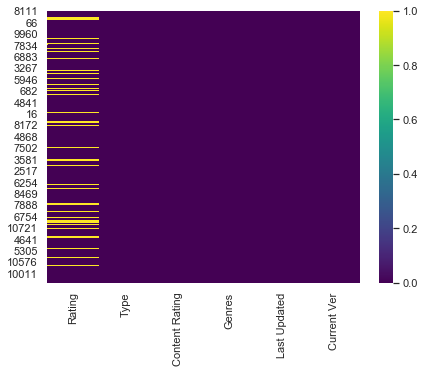

In [392]:
plt.figure(figsize=(7, 5))
sns.heatmap(df[['Rating', 'Type', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']].isnull(), cmap='viridis')
df.isnull().any()

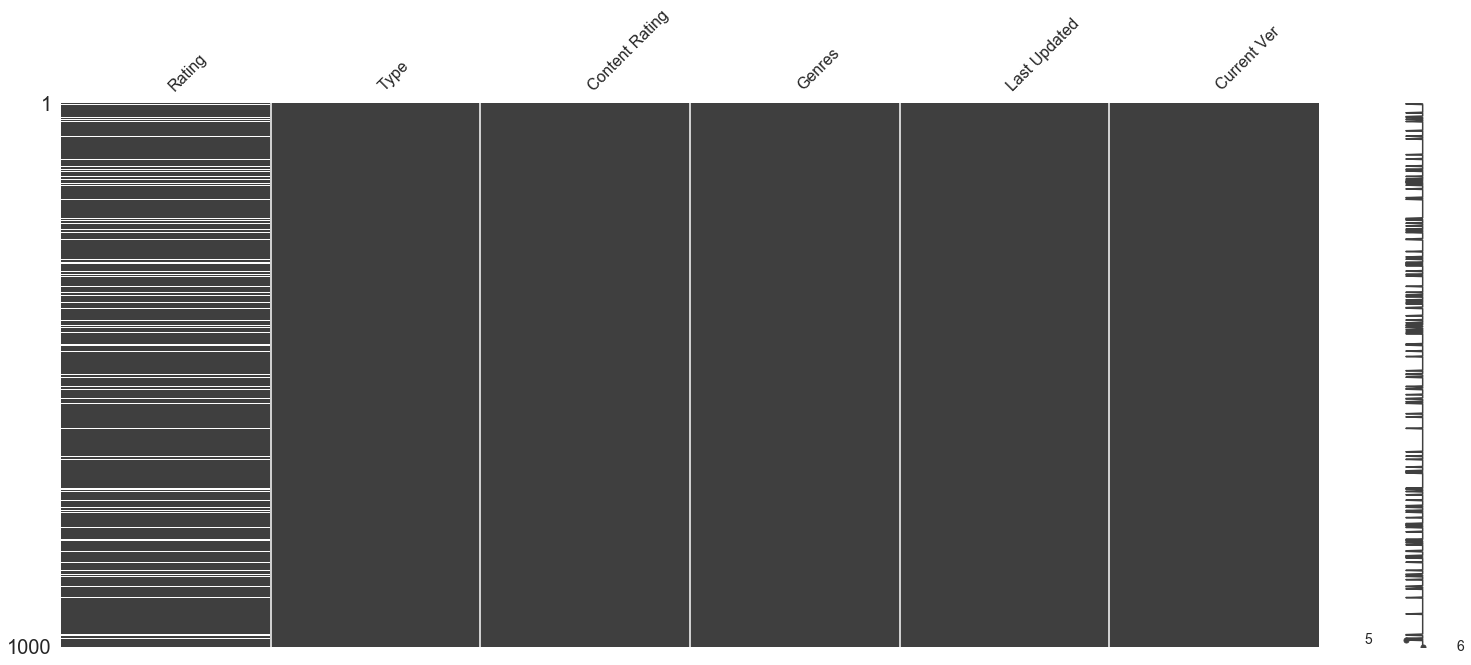

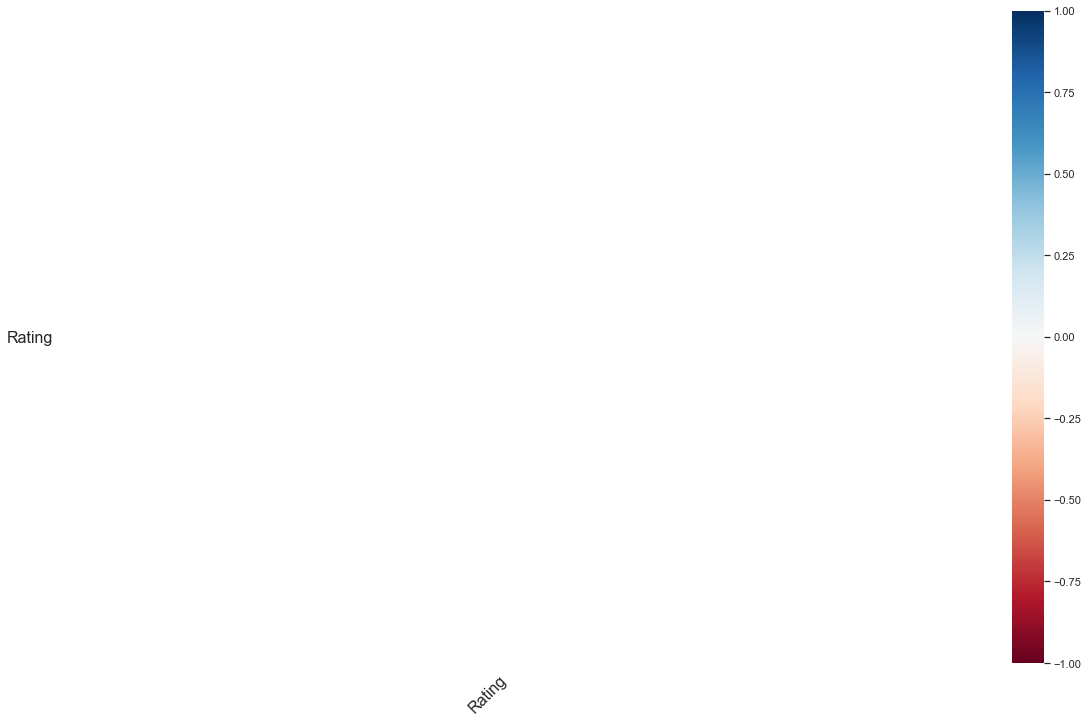

In [393]:
msno.matrix(df[['Rating', 'Type', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']])
msno.heatmap(df[['Rating', 'Type', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']])

Parece que estão faltando valores em "Rating", "Type", "Content Rating" e "Android Ver". Mas a maioria desses valores ausentes na coluna 'Rating'.

In [394]:
df.isnull().sum()

App                 0
Category            0
Rating            129
Reviews             0
Size                0
Installs            0
Type                0
Price               0
Content Rating      0
Genres              0
Last Updated        0
Current Ver         0
Android Ver         0
dtype: int64

Há duas estratégias para manipular dados ausentes, removendo registros com esses valores ausentes ou substituindo valores ausentes por um valor específico como média, mediana ou moda.

In [395]:
# The best way to fill missing values might be using the median instead of mean.
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# Before filling null values we have to clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

In [396]:
# Count the number of unique values in category column 
df['Category'].unique()

array(['PRODUCTIVITY', 'FAMILY', 'BUSINESS', 'SOCIAL', 'HOUSE_AND_HOME',
       'TOOLS', 'GAME', 'VIDEO_PLAYERS', 'COMMUNICATION', 'DATING',
       'ENTERTAINMENT', 'PERSONALIZATION', 'BOOKS_AND_REFERENCE',
       'MEDICAL', 'FINANCE', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'AUTO_AND_VEHICLES', 'LIFESTYLE', 'SHOPPING', 'HEALTH_AND_FITNESS',
       'WEATHER', 'EDUCATION', 'NEWS_AND_MAGAZINES', 'FOOD_AND_DRINK',
       'MAPS_AND_NAVIGATION', 'LIBRARIES_AND_DEMO', 'COMICS',
       'ART_AND_DESIGN', 'BEAUTY', 'PARENTING', 'EVENTS'], dtype=object)

In [397]:
# Check the record  of unreasonable value which is 1.9
i = df[df['Category'] == '1.9'].index
df.loc[i]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


É óbvio que o primeiro valor deste registro está faltando (nome do aplicativo) e todos os outros valores são propagados, respectivamente, começando de "Category" (categoria) para "Current Ver"; e a última coluna, que é "Android Ver", é deixada em branco. É melhor remover esta instância em vez de considerar estes valores durante a limpeza de cada coluna!

In [398]:
# Drop this bad column
df = df.drop(i)

In [399]:
# Removing NaN values
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

# Codificação de dados categóricos

Muitos algoritmos de aprendizado de máquina podem suportar valores categóricos sem manipulação adicional, mas há muito mais algoritmos que não. Precisamos disponibilizar todos os dados para o modelo, portanto, converteremos variáveis categóricas (variáveis armazenadas como valores de texto) em variáveis numéricas.

In [400]:
# App values encoding
le = preprocessing.LabelEncoder()
df['App'] = le.fit_transform(df['App'])
# This encoder converts the values into numeric values

In [401]:
# Category features encoding
category_list = df['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df = pd.concat([df, pd.get_dummies(df['Category'], prefix='cat')], axis=1)

In [402]:
# Genres features encoding
le = preprocessing.LabelEncoder()
df['Genres'] = le.fit_transform(df['Genres'])

In [403]:
# Encode Content Rating features
le = preprocessing.LabelEncoder()
df['Content Rating'] = le.fit_transform(df['Content Rating'])

In [404]:
# Price cealning
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))

In [405]:
# Installs cealning
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

A linha abaixo descarta a coluna de referência e apenas mantém apenas uma das duas colunas, pois reter essa coluna extra não adiciona nenhuma informação nova para o processo de modelagem, esta linha é exatamente a mesma que define o parâmetro drop_first como True.

In [406]:
# Type encoding
df['Type'] = pd.get_dummies(df['Type'])

In [407]:
# Last Updated encoding
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

In [408]:
# Size cealning
df['Size'] = df['Size'].apply(lambda x: x.strip('M').strip('k'))
df[df['Size'] == 'Varies with device'] = 0

# Procedimento de avaliação

Nesta seção, mostramos como o KNN e o Random Forest podem ser usados para prever as avaliações de aplicativos com base nas outras matrizes. Primeiro, o conjunto de dados deve se separar em variáveis dependentes e independentes (ou recursos e rótulos). Então, essas variáveis precisam ser divididas em um conjunto de treinamento e teste.

Durante o estágio de treinamento, damos ao modelo os recursos e os rótulos para que ele possa aprender a classificar os pontos com base nos recursos.

Este script divide o conjunto de dados em 75% de dados de treino e 25% de dados de teste.

In [409]:
# Split data into training and testing sets
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
features.extend(category_list)
X = df[features]
y = df['Rating']

In [410]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

# Mapa de Calor (heatmap)

Criação do mapa de calor para identificar as melhores correlações entre as features.

In [411]:
def generate_heatmap():
    t = pd.DataFrame(data={"col": df.dtypes.index, "type": df.dtypes}).reset_index(drop=True)

    col_names = t["col"][t.type != "object"]

    fig = plt.figure(figsize=(12,12))

    ax = fig.add_subplot(1,1,1)
    cax = ax.matshow(df.corr(), interpolation = 'nearest')

    fig.colorbar(cax)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # ax.set_xticklabels(col_names)
    ax.set_yticklabels(col_names);

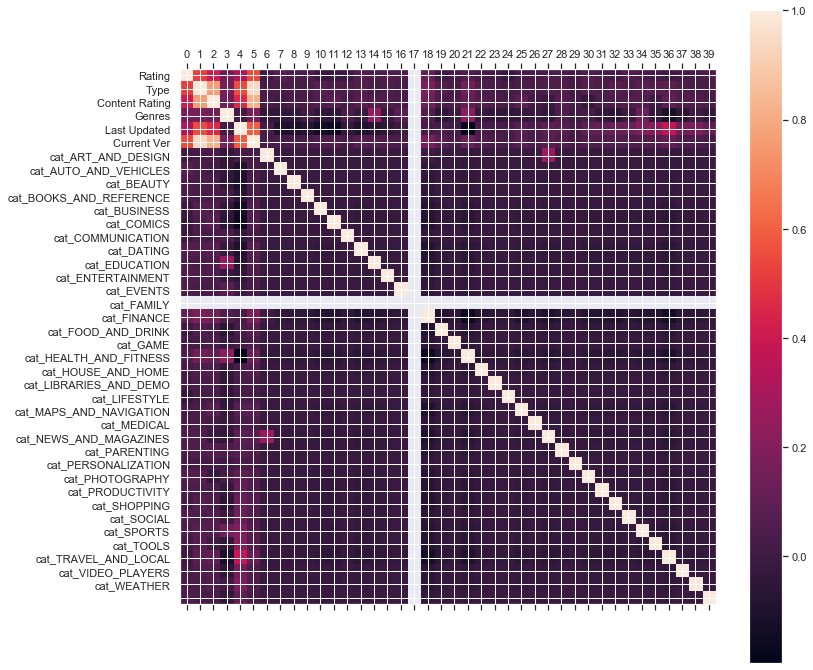

In [412]:
generate_heatmap()

# Modelo  K-Nearest Neighbors (KNN)

O algoritmo de k vizinhos mais próximos baseia-se na ideia simples de prever valores desconhecidos, combinando-os com os valores conhecidos mais semelhantes. Construir o modelo consiste apenas em armazenar o conjunto de dados de treinamento. Para fazer uma previsão para um novo ponto de dados, o algoritmo encontra os pontos de dados mais próximos no conjunto de dados de treinamento - seus "* vizinhos mais próximos *".

In [413]:
# Look at the 15 closest neighbors
knn_model = KNeighborsRegressor(n_neighbors=15)

In [414]:
# Find the mean accuracy of knn regression using X_test and y_test
knn_model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')

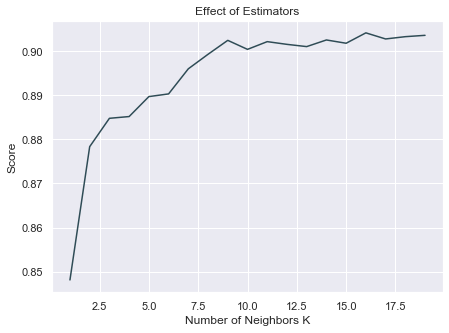

In [415]:
# Try different numbers of n_estimators - this will take a minute or so
n_neighbors = np.arange(1, 20, 1)
scores = []
for n in n_neighbors:
    knn_model.set_params(n_neighbors=n)
    knn_model.fit(X_train, y_train)
    scores.append(knn_model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

# Modelo Random Forest

A classe RandomForestRegressor da biblioteca sklearn.ensemble é usada para resolver problemas de regressão via Random Forest. O parâmetro mais importante da classe RandomForestRegressor é o parâmetro n_estimators. Esse parâmetro define o número de árvores na floresta aleatória.

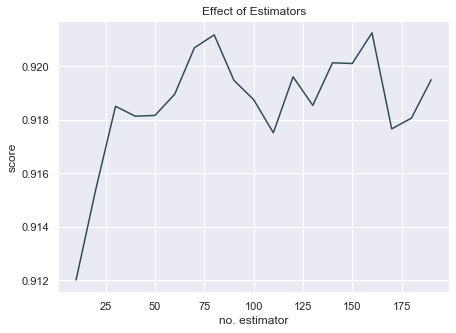

In [416]:
rf_model = RandomForestRegressor(n_jobs=-1)
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rf_model.set_params(n_estimators=n)
    rf_model.fit(X_train, y_train)
    scores.append(rf_model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
results = list(zip(estimators,scores))

# Avaliação dos métodos de regressão - KNN e Random Forest

In [417]:
rf_predictions = rf_model.predict(X_test)
knn_predictions = knn_model.predict(X_test)

In [418]:
knn_accuracy = knn_model.score(X_test,y_test)
'Acurácia - KNN: ' + str(np.round(knn_accuracy*100, 2)) + '%'

'Acurácia - KNN: 90.36%'

In [419]:
rf_accuracy = rf_model.score(X_test,y_test)
'Acurácia - Random Forest: ' + str(np.round(rf_accuracy*100, 2)) + '%'

'Acurácia - Random Forest: 91.95%'

A medida de erro mais comumente usada para aferir a qualidade do ajuste em modelos de regressão, é a RAIZ DO ERRO MÉDIO QUADRÁTICO.

Ela é a raiz do erro médio quadrático da diferença entre a predição e o valor real.
Podemos pensar nela como sendo uma medida análoga ao desvio padrão.

Quanto mais próximo de zero melhor é a qualidade do modelo.

A medida RMSE tem a mesma unidade que os valores de y.

RMSE é uma boa medida, porque geralmente ela representa explicitamente o
que vários métodos tendem a minimizar.

In [420]:
'KNN - Raiz do erro médio quadrático (RMSE):', metrics.mean_squared_error(y_test, knn_predictions)

('KNN - Raiz do erro médio quadrático (RMSE):', 0.23882027700831027)

In [421]:
'Random Forest - Raiz do erro médio quadrático (RMSE):', metrics.mean_squared_error(y_test, rf_predictions)

('Random Forest - Raiz do erro médio quadrático (RMSE):', 0.1995293063711913)

Outra importante medida de ajuste de modelos de regressão é o coeficiente de
determinação, mas conhecido como R².

Ele é definido como 1.0 menos o quanto o modelo tem de de variância
inexplicada, representando uma medida relativa a um modelo nulo que usa
somente a média de y como o preditor.

R-squared é adimensional, e o melhor valor possível para o R-squared é 1.0
(valores pequenos ou negativos de R² não são bons sinais).

In [422]:
'KNN - R²:', r2_score(y_test, knn_predictions)

('KNN - R²:', 0.9036409255404211)

In [423]:
'Random Forest - R²:', r2_score(y_test, rf_predictions)

('Random Forest - R²:', 0.9194940248360036)

Variação explicada: é a distância entre o valor médio de y e os valores estimados pelo modelo para cada y; o somatório do quadrado dos desvios dos valores estimados pelo modelo de regressão yc com relação ao valor médio de y, isto é, (yc – ymédio)2 é sua medida estatística.

In [424]:
'KNN - Variação explicada:', explained_variance_score(y_test, knn_predictions)

('KNN - Variação explicada:', 0.9037945971609793)

In [425]:
'RF - Variação explicada:', explained_variance_score(y_test, rf_predictions)  

('RF - Variação explicada:', 0.9208569519561236)

In [426]:
df.corr()

,App,Rating,Type,Content Rating,Genres,Last Updated,Current Ver,cat_ART_AND_DESIGN,cat_AUTO_AND_VEHICLES,cat_BEAUTY,...,cat_PERSONALIZATION,cat_PHOTOGRAPHY,cat_PRODUCTIVITY,cat_SHOPPING,cat_SOCIAL,cat_SPORTS,cat_TOOLS,cat_TRAVEL_AND_LOCAL,cat_VIDEO_PLAYERS,cat_WEATHER
App,1.000000,0.521557,0.416222,0.160850,0.325773,0.548244,0.009574,0.082931,0.044699,0.054802,...,0.068695,0.042755,0.024214,0.068792,0.043498,0.021875,0.002165,0.024841,0.035931,0.048232
Rating,0.521557,1.000000,0.765643,0.169214,0.552656,0.944120,0.033554,0.038139,0.034048,0.042040,...,0.073625,0.047631,0.084073,0.046919,0.080203,0.079409,0.093327,0.050700,0.038386,0.036609
Type,0.416222,0.765643,1.000000,0.156671,0.459774,0.822482,0.037094,0.007912,0.046021,0.036328,...,-0.023919,0.045758,0.044517,0.063241,0.068247,0.009364,0.105926,0.058814,0.061065,0.036328
Content Rating,0.160850,0.169214,0.156671,1.000000,0.021000,0.174652,-0.029492,-0.031566,-0.036486,0.018030,...,0.029140,-0.025613,-0.050531,0.004212,0.148110,-0.033715,-0.114015,-0.046629,0.007816,-0.028802
Genres,0.325773,0.552656,0.459774,0.021000,1.000000,0.595227,0.029057,-0.093664,-0.101376,-0.077058,...,0.106767,0.115641,0.137482,0.139472,0.205163,0.216147,0.387601,0.163318,0.179539,0.109774
Last Updated,0.548244,0.944120,0.822482,0.174652,0.595227,1.000000,0.030982,0.034915,0.039258,0.031642,...,0.059889,0.063451,0.070895,0.055571,0.070465,0.069228,0.113510,0.051599,0.051638,0.029677
Current Ver,0.009574,0.033554,0.037094,-0.029492,0.029057,0.030982,1.000000,-0.005656,-0.006539,-0.005158,...,-0.010914,-0.011158,-0.012557,-0.008953,-0.011794,-0.011539,-0.020414,-0.008339,-0.008670,-0.005156
cat_ART_AND_DESIGN,0.082931,0.038139,0.007912,-0.031566,-0.093664,0.034915,-0.005656,1.000000,-0.006977,-0.005508,...,-0.011653,-0.011921,-0.013427,-0.009588,-0.012694,-0.012942,-0.021802,-0.008917,-0.009258,-0.005508
cat_AUTO_AND_VEHICLES,0.044699,0.034048,0.046021,-0.036486,-0.101376,0.039258,-0.006539,-0.006977,1.000000,-0.006366,...,-0.013469,-0.013779,-0.015520,-0.011082,-0.014672,-0.014959,-0.025201,-0.010306,-0.010701,-0.006366
cat_BEAUTY,0.054802,0.042040,0.036328,0.018030,-0.077058,0.031642,-0.005158,-0.005508,-0.006366,1.000000,...,-0.010632,-0.010877,-0.012251,-0.008748,-0.011582,-0.011809,-0.019893,-0.008136,-0.008447,-0.005025


Teste de hipótese - média da acurácia

In [427]:
accuracy_knn_sample = np.repeat(np.round(knn_accuracy*100, 2), 30)
accuracy_rf_sample = np.repeat(np.round(rf_accuracy*100, 2), 30)

stat_knn, p_knn = wilcoxon(accuracy_knn_sample, accuracy_rf_sample);
print('Acurácia WILCOXON', stat_knn, p_knn);

Acurácia WILCOXON 0.0 4.320463057827488e-08


Teste de hipótese - RMSE

In [428]:
rmse_knn_sample = np.repeat(metrics.mean_squared_error(y_test, knn_predictions), 30)
rmse_rf_sample = np.repeat(metrics.mean_squared_error(y_test, rf_predictions), 30)

stat_rf, p_rf = wilcoxon(rmse_knn_sample, rmse_rf_sample);
print('RMSE WILCOXON', stat_rf, p_rf);

RMSE WILCOXON 0.0 4.320463057827488e-08
